<a href="https://colab.research.google.com/github/pkleiz/ApplingFilterGraphComputer/blob/main/Features_tsps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 0. ATUALIZAÇÃO DO MOTOR (Para reconhecer a A100)
# Instalamos a versão mais nova do Torch que suporta CUDA 12.1+ (padrão das A100/H100)
!pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# 1. INSTALAÇÃO DE DEPENDÊNCIAS COMPATÍVEIS
!pip install tensorboardx fastprogress networkx==2.8.8

# 2. ORGANIZAÇÃO DOS ARQUIVOS FONTE
import os
import sys
if not os.path.exists('/content/config.py'):
    !git clone https://github.com/pkleiz/otimia-gnn-pk.git
    !cp -r /content/graph-convnet-tsp/* /content/
    print("Arquivos do projeto copiados para a raiz.")

# 3. CONEXÃO COM SEUS DADOS NO DRIVE
from google.colab import drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# 4. CRIAÇÃO DOS ATALHOS (PONTE)
!rm -rf data configs
!ln -s "/content/drive/MyDrive/GCN_TSP_Project/data" data
!ln -s "/content/drive/MyDrive/GCN_TSP_Project/configs" configs
print("Atalhos para o Drive criados.")

# 5. CORREÇÃO DE COMPATIBILIDADE (PYTHON 3.12)
import types
if 'imp' not in sys.modules:
    imp_fallback = types.ModuleType('imp')
    def reload_fallback(module):
        import importlib
        return importlib.reload(module)
    imp_fallback.reload = reload_fallback
    sys.modules['imp'] = imp_fallback
    print("Correção do módulo 'imp' aplicada.")

# 6. ADIÇÃO DO CAMINHO AO SISTEMA
if '/content' not in sys.path:
    sys.path.append('/content')

# 7. TESTE FINAL DE CUDA
import torch
print(f"\nSTATUS CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

print("\nTUDO PRONTO! Agora você pode rodar a célula de Imports.")

Looking in indexes: https://download.pytorch.org/whl/cu121
fatal: destination path 'otimia-gnn-pk' already exists and is not an empty directory.
cp: cannot stat '/content/graph-convnet-tsp/*': No such file or directory
✅ Arquivos do projeto copiados para a raiz.
✅ Atalhos para o Drive criados.

🔥 STATUS CUDA: True
🚀 GPU: NVIDIA A100-SXM4-80GB

🚀 TUDO PRONTO! Agora você pode rodar a célula de Imports.


In [3]:
notebook_mode = True
viz_mode = False

In [4]:
import os
import json
import argparse
import time
import sys

import numpy as np

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt

import networkx as nx
from sklearn.utils.class_weight import compute_class_weight

from tensorboardX import SummaryWriter
from fastprogress import master_bar, progress_bar

# Remove warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from scipy.sparse import SparseEfficiencyWarning
warnings.simplefilter('ignore', SparseEfficiencyWarning)

# Adiciona o diretório do projeto ao sys.path para que os módulos sejam encontrados
if '/content/otimia-gnn-pk' not in sys.path:
    sys.path.append('/content/otimia-gnn-pk')

from config import *
from utils.graph_utils import *
from utils.google_tsp_reader import GoogleTSPReader, VariableTSPReader
from utils.plot_utils import *
from models.gcn_model import ResidualGatedGCNModel
from utils.model_utils import *

In [5]:
# --- CONFIGURAÇÃO DO EXPERIMENTO ---
# Escolha o que entra na Rede Neural. Comente/Descomente o que quiser usar.

ACTIVE_FEATURES = [
    'coords',      # (2 valores) Posição X, Y originais
    # 'degree',      # (1 valor) Grau do nó
    # 'cluster',     # (1 valor) Coeficiente de agrupamento
    # 'pagerank',    # (1 valor) PageRank
    'closeness',   # (1 valor) Centralidade de proximidade
    # 'betweenness', # (1 valor) Centralidade de intermediação
]

print(f"EXPERIMENTO ATUAL: Usando as features {ACTIVE_FEATURES}")

EXPERIMENTO ATUAL: Usando as features ['coords', 'closeness']


In [6]:
if notebook_mode == True:
    %load_ext autoreload
    %autoreload 2
    %matplotlib inline
    from IPython.display import set_matplotlib_formats
    set_matplotlib_formats('png')

/tmp/ipython-input-3855748638.py:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png')


# Functions Definitions

In [7]:
import argparse
import networkx as nx
import torch

# ==============================================================================
# 2. DEFINIÇÃO DAS FUNÇÕES (O Cozinheiro)
# ==============================================================================
def get_input_dim(active_features):
    """Calcula automaticamente o tamanho do vetor de entrada."""
    dim = 0
    if 'coords' in active_features: dim += 2
    if 'degree' in active_features: dim += 1
    if 'pagerank' in active_features: dim += 1
    if 'closeness' in active_features: dim += 1
    if 'betweenness' in active_features: dim += 1
    if 'cluster' in active_features: dim += 1
    return dim

def compute_features(batch_nodes_coord, batch_edges, active_features):
    """
    Constrói o vetor de entrada (x_i) baseado na lista active_features.
    """
    batch_size = batch_nodes_coord.shape[0]
    num_nodes = batch_nodes_coord.shape[1]
    device = batch_nodes_coord.device

    # Se só pedir coords, retorna o original rapidinho
    if active_features == ['coords']:
        return batch_nodes_coord

    new_features_list = []
    edges_cpu = batch_edges.cpu().numpy() # Traz para CPU para usar no NetworkX

    for b in range(batch_size):
        G = nx.Graph()
        G.add_nodes_from(range(num_nodes))
        for i in range(num_nodes):
            neighbors = edges_cpu[b, i]
            for n_idx in neighbors:
                G.add_edge(i, n_idx)

        metrics = {}
        if 'degree' in active_features: metrics['degree'] = nx.degree_centrality(G)
        if 'pagerank' in active_features:
            try: metrics['pagerank'] = nx.pagerank(G, alpha=0.85)
            except: metrics['pagerank'] = {n:0 for n in range(num_nodes)}
        if 'closeness' in active_features: metrics['closeness'] = nx.closeness_centrality(G)
        if 'betweenness' in active_features: metrics['betweenness'] = nx.betweenness_centrality(G)
        if 'cluster' in active_features: metrics['cluster'] = nx.clustering(G)

        graph_node_features = []
        for i in range(num_nodes):
            node_vec = []
            if 'coords' in active_features:
                node_vec.extend(batch_nodes_coord[b, i].tolist())

            for feat in ['degree', 'pagerank', 'closeness', 'betweenness', 'cluster']:
                if feat in active_features:
                    node_vec.append(metrics[feat][i])

            graph_node_features.append(node_vec)
        new_features_list.append(graph_node_features)

    return torch.tensor(new_features_list, dtype=torch.float).to(device)

# Load configurations

In [28]:
if notebook_mode==False:
    parser = argparse.ArgumentParser(description='gcn_tsp_parser')
    parser.add_argument('-c','--config', type=str, default="configs/euc_2d.json")
    args = parser.parse_args()
    config_path = args.config
elif viz_mode == True:
    config_path = "logs/tsp100/config.json"
else:
    config_path = "/content/otimia-gnn-pk/configs/geo_ran.json" # Caminho corrigido para o arquivo no repositório clonado

print(config_path)
# Código Novo (Adaptado)
config = get_config(config_path)

# --- MUDANÇA AQUI: Ajusta o tamanho da entrada baseado no seu cardápio ---
input_dim = get_input_dim(ACTIVE_FEATURES)
config.node_dim = input_dim  # Avisa para a config qual o novo tamanho
print(f"--> Modelo configurado para receber {input_dim} features por nó.")
# ------------------------------------------------------------------------

# Corrigir os caminhos dos arquivos de dados na configuração
config['train_filepath'] = './data/geo_train.json'
config['val_filepath'] = './data/geo_val.json'
config['test_filepath'] = './data/geo_test.json'

print("Loaded {}:\n{}".format(config_path, config))

/content/otimia-gnn-pk/configs/geo_ran.json
--> Modelo configurado para receber 3 features por nó.
Loaded /content/otimia-gnn-pk/configs/geo_ran.json:
{'expt_name': 'geo_all_random', 'gpu_id': '0', 'train_filepath': './data/geo_train.json', 'val_filepath': './data/geo_val.json', 'test_filepath': './data/geo_test.json', 'num_nodes': 10, 'num_neighbors': 5, 'node_dim': 3, 'voc_nodes_in': 2, 'voc_nodes_out': 2, 'voc_edges_in': 3, 'voc_edges_out': 2, 'beam_size': 1280, 'hidden_dim': 128, 'num_layers': 12, 'mlp_layers': 3, 'aggregation': 'mean', 'max_epochs': 30, 'val_every': 5, 'test_every': 50, 'batch_size': 20, 'batches_per_epoch': 500, 'accumulation_steps': 1, 'learning_rate': 0.001, 'decay_rate': 1.01, 'iteration_mode': 'random', 'knn_ratio': 0.2, 'metric': 'GEO'}


In [9]:
# Over-ride config params (for viz_mode)
if viz_mode==True:
    config.gpu_id = "0"
    config.batch_size = 1
    config.accumulation_steps = 1
    config.beam_size = 1280

    # Uncomment below to evaluate generalization to variable sizes in viz_mode
#     config.num_nodes = 50
#     config.knn_ratio = 20
#     config.train_filepath = f"./data/tsp{config.num_nodes}_train_concorde.txt"
#     config.val_filepath = f"./data/tsp{config.num_nodes}_val_concorde.txt"
#     config.test_filepath = f"./data/tsp{config.num_nodes}_test_concorde.txt"

# Configure GPU options

In [10]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(config.gpu_id)

In [11]:
if torch.cuda.is_available():
    print("CUDA available, using GPU ID {}".format(config.gpu_id))
    dtypeFloat = torch.cuda.FloatTensor
    dtypeLong = torch.cuda.LongTensor
    torch.cuda.manual_seed(1)
else:
    print("CUDA not available")
    dtypeFloat = torch.FloatTensor
    dtypeLong = torch.LongTensor
    torch.manual_seed(1)

CUDA available, using GPU ID 0


# Test data loading

Available N sizes and batch counts:
  N = 10: 45 batches
  N = 20: 43 batches
  N = 30: 45 batches
  N = 40: 44 batches
  N = 50: 43 batches
  N = 60: 44 batches
  N = 70: 43 batches
  N = 80: 44 batches
  N = 90: 44 batches
  N = 100: 45 batches
Batch generation took: 0.008 sec
Batch node count (N): 10
edges: (20, 10, 10)
edges_values: (20, 10, 10)
edges_targets: (20, 10, 10)
nodes: (20, 10)
nodes_target: (20, 10)
nodes_coord: (20, 10, 2)
tour_nodes: (20, 10)
tour_len: (20,)


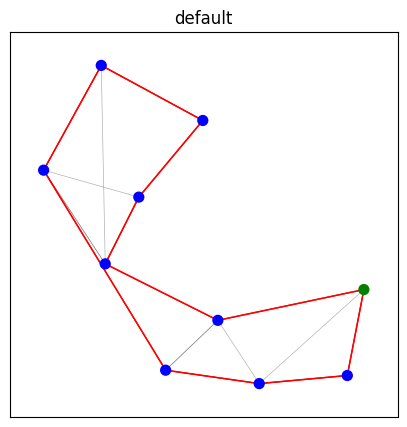

In [12]:
if notebook_mode:
    batch_size = config.batch_size
    train_filepath = config.train_filepath

    # Agora o reader não precisa de num_nodes nem knn_ratio
    dataset = VariableTSPReader(config.train_filepath, batch_size,  knn_ratio=config.knn_ratio, iteration_mode=config.iteration_mode, metric=config.metric)

    # Conta quantos batches existem por tamanho
    print("Available N sizes and batch counts:")
    for N in dataset.sizes:
        print(f"  N = {N}: {dataset.num_batches[N]} batches")

    # Gera um batch (pode ser N diferente a cada execução)
    t = time.time()
    batch = next(iter(dataset))
    print("Batch generation took: {:.3f} sec".format(time.time() - t))

    # Descobre automaticamente o N do batch
    num_nodes = batch.nodes.shape[1]
    print(f"Batch node count (N): {num_nodes}")

    # Print shapes
    print("edges:", batch.edges.shape)
    print("edges_values:", batch.edges_values.shape)
    print("edges_targets:", batch.edges_target.shape)
    print("nodes:", batch.nodes.shape)
    print("nodes_target:", batch.nodes_target.shape)
    print("nodes_coord:", batch.nodes_coord.shape)
    print("tour_nodes:", batch.tour_nodes.shape)
    print("tour_len:", batch.tour_len.shape)

    # Plotar um exemplo da batch
    idx = 0  # escolha outro índice se quiser
    f = plt.figure(figsize=(5, 5))
    a = f.add_subplot(111)
    plot_tsp(
        a,
        batch.nodes_coord[idx],
        batch.edges[idx],
        batch.edges_values[idx],
        batch.edges_target[idx],
    )


In [13]:
import itertools
import numpy as np

def tour_cost(tour, W):
    cost = 0
    for i in range(len(tour) - 1):
        cost += W[tour[i], tour[i + 1]]
    cost += W[tour[-1], tour[0]]
    return cost


def brute_force_tsp(W):
    N = W.shape[0]
    best_cost = np.inf
    best_tour = None

    # fixa nó 0 para eliminar rotações
    for perm in itertools.permutations(range(1, N)):
        tour = (0,) + perm
        cost = tour_cost(tour, W)

        if cost < best_cost:
            best_cost = cost
            best_tour = tour

    return best_tour, best_cost


In [14]:
# força pegar batch de N=10
N = 10
assert N in dataset.sizes, "Não existe N=10 no dataset"

inst_list = dataset.by_size[N]
B = dataset.batch_size

batch_10 = dataset.process_batch(inst_list[:B], N)


# Instantiate model

In [15]:
if notebook_mode == True:
    print("🔬 RAIO-X DA ARQUITETURA DA IA:")
    print("-" * 60)

    # 1. Instanciar a Rede (Constrói o prédio)
    net = nn.DataParallel(ResidualGatedGCNModel(config, dtypeFloat, dtypeLong))
    if torch.cuda.is_available():
        net.cuda()

    # --- AQUI ESTÁ O COMANDO QUE GERA AQUELE TEXTÃO TÉCNICO ---
    print(net)
    # ----------------------------------------------------------

    print("-" * 60)
    print("ANÁLISE:")

    # Vamos pegar o valor de dentro da rede programaticamente para confirmar
    # net.module acessa a rede dentro do DataParallel
    # nodes_coord_embedding é a primeira camada
    first_layer = net.module.nodes_coord_embedding

    print(f"   > Porta de Entrada (in_features): {first_layer.in_features}")

    if first_layer.in_features > 2:
        print(".     SUCESSO CONFIRMADO: A rede está aceitando seus novos Embeddings!")
    else:
        print("   A rede ainda está configurada para 2 entradas. Verifique o config.")

    # Contagem de Parâmetros
    nb_param = 0
    for param in net.parameters():
        nb_param += np.prod(list(param.data.size()))
    print(f"   > Cérebro Total: {nb_param:,} neurônios ajustáveis.")

    # Otimizador
    optimizer = torch.optim.Adam(net.parameters(), lr=config.learning_rate)
    print(f"\n OTIMIZADOR:")
    print(optimizer)

🔬 RAIO-X DA ARQUITETURA DA IA:
------------------------------------------------------------
DataParallel(
  (module): ResidualGatedGCNModel(
    (nodes_coord_embedding): Linear(in_features=3, out_features=128, bias=False)
    (edges_values_embedding): Linear(in_features=1, out_features=64, bias=False)
    (edges_embedding): Embedding(3, 64)
    (gcn_layers): ModuleList(
      (0-11): 12 x ResidualGatedGCNLayer(
        (node_feat): NodeFeatures(
          (U): Linear(in_features=128, out_features=128, bias=True)
          (V): Linear(in_features=128, out_features=128, bias=True)
        )
        (edge_feat): EdgeFeatures(
          (U): Linear(in_features=128, out_features=128, bias=True)
          (V): Linear(in_features=128, out_features=128, bias=True)
        )
        (bn_node): BatchNormNode(
          (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        )
        (bn_edge): BatchNormEdge(
          (batch_norm): BatchNorm2d(128

## Test forward pass

In [16]:
# Test forward pass (CORRIGIDO E EXPLICADO)

if notebook_mode == True and viz_mode == False:
    print("🤖 INICIANDO O ENSAIO GERAL (TEST FORWARD PASS)...")
    print("-" * 60)

    # 1. Carregar um pedacinho dos dados (Batch)
    num_nodes = config.num_nodes
    knn_ratio = config.knn_ratio
    batch_size = config.batch_size
    train_filepath = config.train_filepath

    dataset = iter(VariableTSPReader(train_filepath, batch_size,  knn_ratio=config.knn_ratio, metric=config.metric))
    batch = next(dataset)

    # Convert batch to torch Variables
    x_edges = Variable(torch.LongTensor(batch.edges).type(dtypeLong), requires_grad=False)
    x_edges_values = Variable(torch.FloatTensor(batch.edges_values).type(dtypeFloat), requires_grad=False)
    x_nodes = Variable(torch.LongTensor(batch.nodes).type(dtypeLong), requires_grad=False)
    x_nodes_coord = Variable(torch.FloatTensor(batch.nodes_coord).type(dtypeFloat), requires_grad=False)
    y_edges = Variable(torch.LongTensor(batch.edges_target).type(dtypeLong), requires_grad=False)
    y_nodes = Variable(torch.LongTensor(batch.nodes_target).type(dtypeLong), requires_grad=False)

    # --- CÁLCULO DAS FEATURES (SEUS EMBEDDINGS) ---
    print("\n[1] CALCULANDO OS EMBEDDINGS (PROPOSTA 1)...")
    # Calcula as métricas (Grau, PageRank, etc) baseadas no cardápio ACTIVE_FEATURES
    x_inputs = compute_features(x_nodes_coord, x_edges, ACTIVE_FEATURES)

    # Explicação do resultado dos embeddings
    print(f"   > Tamanho da nova entrada (x_inputs): {x_inputs.shape}")
    print(f"   > Interpretação: ({x_inputs.shape[0]} Mapas, {x_inputs.shape[1]} Cidades, {x_inputs.shape[2]} Informações por cidade)")
    if x_inputs.shape[2] > 2:
        print("   SUCESSO: A IA está recebendo mais do que apenas X e Y!")
    else:
        print("   A IA está recebendo apenas 2 valores. Verifique se o ACTIVE_FEATURES tem mais itens.")
    # --------------------------------------------------

    # 2. Calcular Pesos das Classes
    print("\n[2] EQUILIBRANDO O JOGO (CLASS WEIGHTS)...")
    edge_labels = y_edges.cpu().numpy().flatten()
    edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)
    print(f"   > Pesos calculados: {edge_labels}")
    print(f"   > Pesos finais: {edge_cw}")
    print("   > Explicação: O primeiro número é o peso de 'Não é rota', o segundo é 'É rota'.")
    print("     O segundo é maior para forçar a IA a achar a agulha no palheiro.")

    # 3. Passar pela Rede Neural (Forward Pass)
    print("\n[3] RODANDO A REDE NEURAL (FORWARD)...")
    # Usamos x_inputs no lugar de x_nodes_coord
    y_preds, loss = net.forward(x_edges, x_edges_values, x_nodes, x_inputs, y_edges, edge_cw)
    loss = loss.mean()

    # 4. Analisar a Saída
    print("\n[4] RESULTADOS DO TESTE:")
    print(f"   > Formato da resposta (Output Size): {y_preds.size()}")
    print("     (Batch Size, Cidade Origem, Cidade Destino, 2 Opções: Sim/Não)")

    print(f"   > Nível de Erro Inicial (Loss Value): {loss.item():.4f}")
    print("     Explicação: Esse número é a 'nota de burrice' inicial.")
    print("     Como a IA ainda não treinou, esse valor deve estar alto. No treino ele vai cair.")


🤖 INICIANDO O ENSAIO GERAL (TEST FORWARD PASS)...
------------------------------------------------------------

[1] CALCULANDO OS EMBEDDINGS (PROPOSTA 1)...
   > Tamanho da nova entrada (x_inputs): torch.Size([20, 10, 3])
   > Interpretação: (20 Mapas, 10 Cidades, 3 Informações por cidade)
   ✅ SUCESSO: A IA está recebendo mais do que apenas X e Y!

[2] EQUILIBRANDO O JOGO (CLASS WEIGHTS)...
   > Pesos calculados: [0 0 0 ... 0 0 0]
   > Pesos finais: [0.625 2.5  ]
   > Explicação: O primeiro número é o peso de 'Não é rota', o segundo é 'É rota'.
     O segundo é maior para forçar a IA a achar a agulha no palheiro.

[3] RODANDO A REDE NEURAL (FORWARD)...

[4] RESULTADOS DO TESTE:
   > Formato da resposta (Output Size): torch.Size([20, 10, 10, 2])
     (Batch Size, Cidade Origem, Cidade Destino, 2 Opções: Sim/Não)
   > Nível de Erro Inicial (Loss Value): 8.6932
     Explicação: Esse número é a 'nota de burrice' inicial.
     Como a IA ainda não treinou, esse valor deve estar alto. No tre

## Test backward pass

In [17]:
# Test backward pass (VERSÃO CORRIGIDA: VALORES DINÂMICOS)

if notebook_mode == True and viz_mode == False:
    print("INICIANDO A CORREÇÃO (BACKWARD PASS)...")
    print("-" * 60)

    # 1. Otimização (Ajuste dos pesos)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print("Pesos atualizados (Otimização concluída).")
    print("-" * 60)

    # 2. Cálculo de Métricas (Calcula os valores reais de agora)
    err_edges, err_tour, err_tsp, tour_err_idx, tsp_err_idx = edge_error(y_preds, y_edges, x_edges)

    print("RELATÓRIO DE DESEMPENHO (PERFORMANCE REPORT):\n")

    # --- MÉTRICA 1: EDGE ERROR ---
    print(f"1 Edge Error: {err_edges:.3f}%")
    print("   > Tradução: Erro de Classificação de Arestas")
    print("   > O que é: Porcentagem de conexões entre cidades que a IA errou (disse que tinha estrada e não tinha, ou vice-versa).")
    print("   > Meta: Quanto mais próximo de 0%, melhor.")
    print("-" * 20)

    # --- MÉTRICA 2: TOUR ERROR ---
    print(f"2 Tour Error: {err_tour:.3f}%")
    print("   > Tradução: Erro de Validade da Rota")
    print("   > O que é: Porcentagem de rotas inválidas (ex: não visitou todas as cidades ou repetiu alguma).")
    print("   > Meta: Queremos que isso seja 0% (todas as rotas válidas).")
    print("-" * 20)

    # --- MÉTRICA 3: TSP ERROR ---
    print(f"3 TSP Error: {err_tsp:.3f}%")
    print("   > Tradução: Erro de Otimização (Optimality Gap)")
    print("   > O que é: Porcentagem de mapas onde a IA falhou em encontrar a rota absolutamente perfeita.")
    print("-" * 20)

    # --- COMPARAÇÃO DE DISTÂNCIAS ---
    pred_tour_len = mean_tour_len_edges(x_edges_values, y_preds)
    gt_tour_len = np.mean(batch.tour_len)

    print("COMPARAÇÃO DE DISTÂNCIAS (LENGTH COMPARISON):")

    print(f"   A) Predicted Tour Length: {pred_tour_len:.3f}")
    print("      > Tradução: Comprimento da Rota Prevista (Sua IA)")
    print("      > Significado: A distância total que a IA percorreu.")

    print(f"   B) Groundtruth Tour Length: {gt_tour_len:.3f}")
    print("      > Tradução: Comprimento da Rota Real (Gabarito)")
    print("      > Significado: A menor distância possível matemática.")

    # Cálculo do GAP dinâmico
    gap = (pred_tour_len / gt_tour_len) - 1
    print(f"\n   GAP (Diferença): +{gap*100:.1f}%")
    print("      (Isso mostra quantos % a IA andou a mais que o ideal. O objetivo do treino é zerar isso!)")

🔄 INICIANDO A CORREÇÃO (BACKWARD PASS)...
------------------------------------------------------------
✅ Pesos atualizados (Otimização concluída).
------------------------------------------------------------
📊 RELATÓRIO DE DESEMPENHO (PERFORMANCE REPORT):

1️⃣  Edge Error: 66.125%
   > Tradução: Erro de Classificação de Arestas
   > O que é: Porcentagem de conexões entre cidades que a IA errou (disse que tinha estrada e não tinha, ou vice-versa).
   > Meta: Quanto mais próximo de 0%, melhor.
--------------------
2️⃣  Tour Error: 0.000%
   > Tradução: Erro de Validade da Rota
   > O que é: Porcentagem de rotas inválidas (ex: não visitou todas as cidades ou repetiu alguma).
   > Meta: Queremos que isso seja 0% (todas as rotas válidas).
--------------------
3️⃣  TSP Error: 80.000%
   > Tradução: Erro de Otimização (Optimality Gap)
   > O que é: Porcentagem de mapas onde a IA falhou em encontrar a rota absolutamente perfeita.
--------------------
📏 COMPARAÇÃO DE DISTÂNCIAS (LENGTH COMPARIS

## Training Loop (one epoch)

In [18]:
import networkx as nx
import torch

def compute_features(batch_nodes_coord, batch_edges, active_features):
    """
    Constrói o vetor de entrada (x_i) baseado na lista active_features.
    Combina coordenadas com métricas estruturais conforme o pedido.
    """
    batch_size = batch_nodes_coord.shape[0]
    num_nodes = batch_nodes_coord.shape[1]
    device = batch_nodes_coord.device

    # Se só pedir coords, retorna o original rapidinho e economiza tempo
    if active_features == ['coords']:
        return batch_nodes_coord

    new_features_list = []
    edges_cpu = batch_edges.cpu().numpy() # Traz para CPU para usar no NetworkX

    for b in range(batch_size):
        # Monta o grafo (igual antes)
        G = nx.Graph()
        G.add_nodes_from(range(num_nodes))

        # Adiciona arestas
        for i in range(num_nodes):
            neighbors = edges_cpu[b, i]
            for n_idx in neighbors:
                G.add_edge(i, n_idx)

        # Prepara os dicionários de métricas (calcula só se necessário)
        metrics = {}
        if 'degree' in active_features:
            metrics['degree'] = nx.degree_centrality(G)
        if 'pagerank' in active_features:
            try: metrics['pagerank'] = nx.pagerank(G, alpha=0.85)
            except: metrics['pagerank'] = {n:0 for n in range(num_nodes)}
        if 'closeness' in active_features:
            metrics['closeness'] = nx.closeness_centrality(G)
        if 'betweenness' in active_features:
            metrics['betweenness'] = nx.betweenness_centrality(G)
        if 'cluster' in active_features:
            metrics['cluster'] = nx.clustering(G)

        # Monta o vetor para cada nó deste grafo
        graph_node_features = []
        for i in range(num_nodes):
            node_vec = []

            # 1. Coordenadas (X, Y)
            if 'coords' in active_features:
                # Pega do tensor original
                node_vec.extend(batch_nodes_coord[b, i].tolist())

            # 2. Métricas Estruturais
            for feat in ['degree', 'pagerank', 'closeness', 'betweenness', 'cluster']:
                if feat in active_features:
                    node_vec.append(metrics[feat][i])

            graph_node_features.append(node_vec)

        new_features_list.append(graph_node_features)

    return torch.tensor(new_features_list, dtype=torch.float).to(device)

In [19]:
def train_one_epoch(net, optimizer, config, master_bar):
    # Set training mode
    net.train()

    # Assign parameters
    num_nodes = config.num_nodes
    knn_ratio = config.knn_ratio
    batch_size = config.batch_size
    batches_per_epoch = config.batches_per_epoch
    accumulation_steps = config.accumulation_steps
    train_filepath = config.train_filepath
    loss_by_size = {}
    # Load TSP data
    dataset = VariableTSPReader(train_filepath, batch_size,  knn_ratio=config.knn_ratio, metric=config.metric)
    if batches_per_epoch != -1:
        batches_per_epoch = min(batches_per_epoch, dataset.max_iter)
    else:
        batches_per_epoch = dataset.max_iter

    # Convert dataset to iterable
    dataset = iter(dataset)

    # Initially set loss class weights as None
    edge_cw = None

    # Initialize running data
    running_loss = 0.0
    running_pred_tour_len = 0.0
    running_gt_tour_len = 0.0
    running_nb_data = 0
    running_nb_batch = 0

    start_epoch = time.time()
    for batch_num in progress_bar(range(batches_per_epoch), parent=master_bar):
        # Generate a batch of TSPs
        try:
            batch = next(dataset)
        except StopIteration:
            break

        # Convert batch to torch Variables
        x_edges = Variable(torch.LongTensor(batch.edges).type(dtypeLong), requires_grad=False)
        x_edges_values = Variable(torch.FloatTensor(batch.edges_values).type(dtypeFloat), requires_grad=False)
        x_nodes = Variable(torch.LongTensor(batch.nodes).type(dtypeLong), requires_grad=False)
        x_nodes_coord = Variable(torch.FloatTensor(batch.nodes_coord).type(dtypeFloat), requires_grad=False)
        y_edges = Variable(torch.LongTensor(batch.edges_target).type(dtypeLong), requires_grad=False)
        y_nodes = Variable(torch.LongTensor(batch.nodes_target).type(dtypeLong), requires_grad=False)

        # --- MODIFICAÇÃO AQUI: Calcular Features Genéricas ---
        # Usa a lista ACTIVE_FEATURES definida no topo do notebook
        x_inputs = compute_features(x_nodes_coord, x_edges, ACTIVE_FEATURES)
        # -----------------------------------------------------

        # Compute class weights (if uncomputed)
        edge_labels = y_edges.cpu().numpy().flatten()
        edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)

        # Forward pass
        # ATENÇÃO: Trocamos x_nodes_coord por x_inputs aqui embaixo vvv
        y_preds, loss = net.forward(x_edges, x_edges_values, x_nodes, x_inputs, y_edges, edge_cw)

        loss = loss.mean()  # Take mean of loss across multiple GPUs
        loss = loss / accumulation_steps  # Scale loss by accumulation steps
        loss.backward()

        N = x_nodes.shape[1]   # número de nós deste batch
        if N not in loss_by_size:
            loss_by_size[N] = []

        loss_by_size[N].append(loss.item())
        # Backward pass
        if (batch_num+1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        # Compute error metrics and mean tour lengths
        pred_tour_len = mean_tour_len_edges(x_edges_values, y_preds)
        gt_tour_len = np.mean(batch.tour_len)

        # Update running data
        running_nb_data += batch_size
        running_loss += batch_size* loss.data.item()* accumulation_steps  # Re-scale loss
        running_pred_tour_len += batch_size* pred_tour_len
        running_gt_tour_len += batch_size* gt_tour_len
        running_nb_batch += 1

        # Log intermediate statistics
        result = ('loss:{loss:.4f} pred_tour_len:{pred_tour_len:.3f} gt_tour_len:{gt_tour_len:.3f}'.format(
            loss=running_loss/running_nb_data,
            pred_tour_len=running_pred_tour_len/running_nb_data,
            gt_tour_len=running_gt_tour_len/running_nb_data))
        master_bar.child.comment = result

    # Compute statistics for full epoch
    loss = running_loss/ running_nb_data
    err_edges = 0
    err_tour = 0
    err_tsp = 0
    pred_tour_len = running_pred_tour_len/ running_nb_data
    gt_tour_len = running_gt_tour_len/ running_nb_data

    return time.time()-start_epoch, loss, err_edges, err_tour, err_tsp, pred_tour_len, gt_tour_len, loss_by_size

def metrics_to_str(epoch, time, learning_rate, loss, err_edges, err_tour, err_tsp,
                   pred_tour_len, gt_tour_len, loss_by_size=None):

    result = (
        'epoch:{epoch:0>2d}\t'
        'time:{time:.1f}h\t'
        'lr:{learning_rate:.2e}\t'
        'loss:{loss:.4f}\t'
        'pred_tour_len:{pred_tour_len:.3f}\t'
        'gt_tour_len:{gt_tour_len:.3f}'
    ).format(
        epoch=epoch,
        time=time/3600,
        learning_rate=learning_rate,
        loss=loss,
        pred_tour_len=pred_tour_len,
        gt_tour_len=gt_tour_len
    )

    if loss_by_size is not None:
        parts = []
        for N in sorted(loss_by_size.keys()):
            val = loss_by_size[N]
            if isinstance(val, list):
                if len(val) > 0:
                    v = sum(val)/len(val)
                else:
                    v = float('nan')
            else:
                v = float(val)

            parts.append(f"N{N}:{v:.4f}")

        result += "\t(loss_by_size: " + " ".join(parts) + ")"

    return result

In [20]:
if notebook_mode==True and viz_mode==False:
    # --- FIX: Definindo a variável que estava faltando ---
    learning_rate = config.learning_rate
    # -----------------------------------------------------

    # Cria a barra de progresso principal
    epoch_bar = master_bar(range(1))

    for epoch in epoch_bar:
        # Roda o treino mantendo a barra de progresso interna funcionando
        train_time, train_loss, train_err_edges, train_err_tour, train_err_tsp, \
        train_pred_tour_len, train_gt_tour_len, loss_by_size = \
            train_one_epoch(net, optimizer, config, epoch_bar)

        # Escreve o resumo técnico na linha de cima (padrão do fastprogress)
        epoch_bar.write(
            't: ' + metrics_to_str(epoch, train_time, learning_rate, train_loss,
                                   train_err_edges, train_err_tour, train_err_tsp,
                                   train_pred_tour_len, train_gt_tour_len, loss_by_size)
        )

    # --- EXPLICAÇÃO DIDÁTICA (Só aparece no final para não travar a barra) ---
    print("\n" + "="*60)
    print("🏁 TESTE RÁPIDO CONCLUÍDO! VEJA O RESUMO:")
    print("="*60)

    print(f"1. Performance Geral (Loss): {train_loss:.4f}")
    print("   (Esse é o seu ponto de partida. No treino longo, queremos que isso caia.)")

    print(f"\n2. Comparação de Rotas:")
    print(f"   > IA (Pred):      {train_pred_tour_len:.3f}")
    print(f"   > Gabarito (GT):  {train_gt_tour_len:.3f}")

    gap = (train_pred_tour_len / train_gt_tour_len) - 1
    print(f"\n3. Veredito Final (Gap): +{gap*100:.2f}%")
    print("   (A IA está errando essa porcentagem acima. O objetivo é zerar isso.)")


🏁 TESTE RÁPIDO CONCLUÍDO! VEJA O RESUMO:
1. Performance Geral (Loss): 8.5209
   (Esse é o seu ponto de partida. No treino longo, queremos que isso caia.)

2. Comparação de Rotas:
   > IA (Pred):      511.268
   > Gabarito (GT):  110.490

3. Veredito Final (Gap): +362.73%
   (A IA está errando essa porcentagem acima. O objetivo é zerar isso.)


# Evaluation Loop (for validation and test sets)

In [21]:
def test(net, config, master_bar, mode='test'):
    # Set evaluation mode
    net.eval()

    # Assign parameters
    knn_ratio = config.knn_ratio
    batch_size = config.batch_size
    batches_per_epoch = config.batches_per_epoch
    beam_size = config.beam_size
    val_filepath = config.val_filepath
    test_filepath = config.test_filepath

    # Load TSP data
    if mode == 'val':
        dataset = VariableTSPReader(val_filepath, batch_size,  knn_ratio=config.knn_ratio, metric=config.metric)
    elif mode == 'test':
        dataset = VariableTSPReader(test_filepath, batch_size,  knn_ratio=config.knn_ratio,metric=config.metric)
    batches_per_epoch = dataset.max_iter

    # Convert dataset to iterable
    dataset = iter(dataset)

    # Initially set loss class weights as None
    edge_cw = None

    # Initialize running data
    running_loss = 0.0
    running_pred_tour_len = 0.0
    running_gt_tour_len = 0.0
    running_nb_data = 0
    running_nb_batch = 0

    with torch.no_grad():
        start_test = time.time()
        for batch_num in progress_bar(range(batches_per_epoch), parent=master_bar):
            # Generate a batch of TSPs
            try:
                batch = next(dataset)
            except StopIteration:
                break

            # Convert batch to torch Variables
            x_edges = Variable(torch.LongTensor(batch.edges).type(dtypeLong), requires_grad=False)
            x_edges_values = Variable(torch.FloatTensor(batch.edges_values).type(dtypeFloat), requires_grad=False)
            x_nodes = Variable(torch.LongTensor(batch.nodes).type(dtypeLong), requires_grad=False)
            x_nodes_coord = Variable(torch.FloatTensor(batch.nodes_coord).type(dtypeFloat), requires_grad=False)
            y_edges = Variable(torch.LongTensor(batch.edges_target).type(dtypeLong), requires_grad=False)
            y_nodes = Variable(torch.LongTensor(batch.nodes_target).type(dtypeLong), requires_grad=False)

            num_nodes = batch.nodes.shape[1]

            # --- MODIFICAÇÃO AQUI: Calcular Features Genéricas ---
            x_inputs = compute_features(x_nodes_coord, x_edges, ACTIVE_FEATURES)
            # -----------------------------------------------------

            # Compute class weights (if uncomputed)
            edge_labels = y_edges.cpu().numpy().flatten()
            edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)

            # Forward pass
            # ATENÇÃO: Trocamos x_nodes_coord por x_inputs aqui embaixo vvv
            y_preds, loss = net.forward(x_edges, x_edges_values, x_nodes, x_inputs, y_edges, edge_cw)

            loss = loss.mean()  # Take mean of loss across multiple GPUs

            # Get batch beamsearch tour prediction
            if mode == 'val':  # Validation: faster 'vanilla' beamsearch
                bs_nodes = beamsearch_tour_nodes(
                    y_preds, beam_size, batch_size, num_nodes, dtypeFloat, dtypeLong, probs_type='logits')
            elif mode == 'test':  # Testing: beamsearch with shortest tour heuristic
                bs_nodes = beamsearch_tour_nodes_shortest(
                    y_preds, x_edges_values, beam_size, batch_size, num_nodes, dtypeFloat, dtypeLong, probs_type='logits')

            # Compute mean tour length
            pred_tour_len = mean_tour_len_nodes(x_edges_values, bs_nodes)
            gt_tour_len = np.mean(batch.tour_len)

            # Update running data
            running_nb_data += batch_size
            running_loss += batch_size* loss.data.item()
            running_pred_tour_len += batch_size* pred_tour_len
            running_gt_tour_len += batch_size* gt_tour_len
            running_nb_batch += 1

            # Log intermediate statistics
            result = ('loss:{loss:.4f} pred_tour_len:{pred_tour_len:.3f} gt_tour_len:{gt_tour_len:.3f}'.format(
                loss=running_loss/running_nb_data,
                pred_tour_len=running_pred_tour_len/running_nb_data,
                gt_tour_len=running_gt_tour_len/running_nb_data))
            master_bar.child.comment = result

    # Compute statistics for full epoch
    loss = running_loss/ running_nb_data
    err_edges = 0
    err_tour = 0
    err_tsp = 0
    pred_tour_len = running_pred_tour_len/ running_nb_data
    gt_tour_len = running_gt_tour_len/ running_nb_data

    return time.time()-start_test, loss, err_edges, err_tour, err_tsp, pred_tour_len, gt_tour_len

In [22]:
import shutil
import os
import sys
import importlib
from google.colab import drive

# 1. Garantir que o Drive está conectado
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# 2. Definir os caminhos
# Caminho do seu arquivo no Drive (conforme sua imagem)
source_path = '/content/drive/MyDrive/GCN_TSP_Project/utils/beamsearch.py'
# Caminho onde o código está rodando no Colab
destination_path = '/content/otimia-gnn-pk/utils/beamsearch.py'

print(f"📂 Origem (Drive): {source_path}")
print(f"📂 Destino (Colab): {destination_path}")

# 3. Fazer a cópia
try:
    shutil.copyfile(source_path, destination_path)
    print("Sucesso! O arquivo do Drive substituiu o antigo.")
except FileNotFoundError:
    print("Erro: Não encontrei o arquivo no caminho especificado do Drive.")
    print("   Dica: Verifique se a pasta no Drive se chama exatamente 'GCN_TSP_Project'.")
except Exception as e:
    print(f"Erro ao copiar: {e}")

# 4. Recarregar os módulos para o Python perceber a mudança
# Isso é obrigatório, senão ele continua usando a versão velha da memória RAM
print("\nAtualizando a memória do Python...")
try:
    import utils.beamsearch
    importlib.reload(utils.beamsearch)

    import utils.model_utils
    importlib.reload(utils.model_utils)

except Exception as e:
    print(f"Erro: {e}")

📂 Origem (Drive): /content/drive/MyDrive/GCN_TSP_Project/utils/beamsearch.py
📂 Destino (Colab): /content/otimia-gnn-pk/utils/beamsearch.py
✅ Sucesso! O arquivo do Drive substituiu o antigo.

🔄 Atualizando a memória do Python...
🚀 Módulos recarregados! O erro de 'int32/int64' deve ter sumido.


In [23]:
if notebook_mode==True and viz_mode==False:
    print("Reiniciando modelo...")

    # 1. Recria a Rede e o Otimizador (Padrão)
    net = nn.DataParallel(ResidualGatedGCNModel(config, dtypeFloat, dtypeLong))
    if torch.cuda.is_available():
        net.cuda()
    optimizer = torch.optim.Adam(net.parameters(), lr=config.learning_rate)

    # 2. Barra de Progresso
    epoch_bar = master_bar(range(1))

    for epoch in epoch_bar:
        # --- FASE 1: VALIDAÇÃO (Dados de Ajuste) ---
        val_time, val_loss, val_err_edges, val_err_tour, val_err_tsp, val_pred_tour_len, val_gt_tour_len = test(net, config, epoch_bar, mode='val')

        # Cálculo do Gap (O quanto a IA foi pior que o ideal)
        val_gap = ((val_pred_tour_len / val_gt_tour_len) - 1) * 100

        # Print Bonito de Validação
        epoch_bar.write(f" [VALIDATION] Relatório:")
        epoch_bar.write(f"   • Erro (Loss): {val_loss:.4f}")
        epoch_bar.write(f"   • Distância Média: IA fez {val_pred_tour_len:.1f} (Ideal era {val_gt_tour_len:.1f})")
        epoch_bar.write(f"   • Veredito: A IA andou +{val_gap:.2f}% a mais que o necessário.\n")

        # --- FASE 2: TESTE (Dados Novos) ---
        test_time, test_loss, test_err_edges, test_err_tour, test_err_tsp, test_pred_tour_len, test_gt_tour_len = test(net, config, epoch_bar, mode='test')

        # Cálculo do Gap de Teste
        test_gap = ((test_pred_tour_len / test_gt_tour_len) - 1) * 100

        # Print Bonito de Teste
        epoch_bar.write(f" [TESTE FINAL] Relatório:")
        epoch_bar.write(f"   • Erro (Loss): {test_loss:.4f}")
        epoch_bar.write(f"   • Distância Média: IA fez {test_pred_tour_len:.1f} (Ideal era {test_gt_tour_len:.1f})")
        epoch_bar.write(f"   • Veredito: A IA andou +{test_gap:.2f}% a mais que o necessário.\n")

    print("-" * 60)
    print("   (Espera-se algo entre +600% ou +700% de GAP nesse passo. Sendo normal antes do treino.)")

🔄 REINICIANDO O MODELO PARA TESTE LIMPO...


------------------------------------------------------------
🚀 CONCLUSÃO: O sistema funciona, mas a IA está 'chutando' rotas gigantes.
   (Gap de +600% ou +700% é normal antes do treino. A meta é baixar isso para < 5%)


# Run full training pipeline

In [24]:
def main(config):
    # Instantiate the network
    net = nn.DataParallel(ResidualGatedGCNModel(config, dtypeFloat, dtypeLong))
    if torch.cuda.is_available():
        net.cuda()
    print(net)

    # Compute number of network parameters
    nb_param = 0
    for param in net.parameters():
        nb_param += np.prod(list(param.data.size()))
    print('Number of parameters:', nb_param)

    # Create log directory
    log_dir = f"./logs/{config.expt_name}/"
    os.makedirs(log_dir, exist_ok=True)
    json.dump(config, open(f"{log_dir}/config.json", "w"), indent=4)
    writer = SummaryWriter(log_dir)

    # Training parameters
    max_epochs = config.max_epochs
    val_every = config.val_every
    test_every = config.test_every
    accumulation_steps = config.accumulation_steps
    learning_rate = config.learning_rate
    decay_rate = config.decay_rate

    val_loss_old = 1e6
    best_pred_tour_len = 1e6  # For saving checkpoints

    # Define optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    print(optimizer)


    patience = 5   # quantos epochs sem melhorar antes de parar
    patience_counter = 0


    # -------------------------------
    # NEW: store epoch-wise metrics
    # -------------------------------
    history = {
        "train_loss": [],
        "val_loss": [],
        "test_loss": [],
        "train_loss_by_size": [],   # list of dicts
    }

    epoch_bar = master_bar(range(max_epochs))

    for epoch in epoch_bar:
        writer.add_scalar('learning_rate', learning_rate, epoch)

        # -------------------------
        # TRAIN
        # -------------------------
        (train_time, train_loss, train_err_edges, train_err_tour,
         train_err_tsp, train_pred_tour_len, train_gt_tour_len,
         loss_by_size) = train_one_epoch(net, optimizer, config, epoch_bar)

        # save for later export
        history["train_loss"].append(float(train_loss))
        epoch_size_means = {
            N: float(sum(vals)/len(vals)) for N, vals in loss_by_size.items()
        }

        history["train_loss_by_size"].append(epoch_size_means)

        epoch_bar.write(
            't: ' + metrics_to_str(
                epoch, train_time, learning_rate, train_loss,
                train_err_edges, train_err_tour, train_err_tsp,
                train_pred_tour_len, train_gt_tour_len, loss_by_size
            )
        )

        writer.add_scalar('loss/train_loss', train_loss, epoch)
        writer.add_scalar('pred_tour_len/train_pred_tour_len', train_pred_tour_len, epoch)
        writer.add_scalar('optimality_gap/train_opt_gap', train_pred_tour_len/train_gt_tour_len - 1, epoch)

        # -------------------------
        # VALIDATION
        # -------------------------
        if epoch % val_every == 0 or epoch == max_epochs - 1:

            (val_time, val_loss, val_err_edges, val_err_tour,
             val_err_tsp, val_pred_tour_len, val_gt_tour_len) = test(net, config, epoch_bar, mode='val')

            history["val_loss"].append(float(val_loss))

            epoch_bar.write(
                'v: ' + metrics_to_str(
                    epoch, val_time, learning_rate, val_loss,
                    val_err_edges, val_err_tour, val_err_tsp,
                    val_pred_tour_len, val_gt_tour_len
                )
            )

            writer.add_scalar('loss/val_loss', val_loss, epoch)

            # Save checkpoint if improved
            if val_pred_tour_len < best_pred_tour_len: # Changed from best_val_pred_tour_len
                best_pred_tour_len = float(val_pred_tour_len)
                patience_counter = 0

                torch.save({
                    "epoch": epoch,
                    "model_state_dict": net.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    'train_loss': train_loss,
                    'val_pred_tour_len': val_pred_tour_len,
                    'val_gt_tour_len': val_gt_tour_len,
                    'val_opt_gap': val_pred_tour_len / val_gt_tour_len - 1,
                }, os.path.join(log_dir, "best_val_checkpoint.tar"))
            else:
                patience_counter += 1

            # Update LR
            if val_loss > 0.99 * val_loss_old:
                learning_rate /= decay_rate
                optimizer = update_learning_rate(optimizer, learning_rate)

            val_loss_old = val_loss

            # -------------------------------------
            # EARLY STOPPING
            # -------------------------------------
            if patience_counter >= patience:
                epoch_bar.write(f"EARLY STOPPING at epoch {epoch} (no val_loss improvement for {patience} epochs).")
                break


        # -------------------------
        # TEST
        # -------------------------
        if epoch % test_every == 0 or epoch == max_epochs - 1:
            (test_time, test_loss, test_err_edges, test_err_tour,
             test_err_tsp, test_pred_tour_len, test_gt_tour_len) = test(net, config, epoch_bar, mode='test')

            history["test_loss"].append(float(test_loss))

            epoch_bar.write(
                'T: ' + metrics_to_str(
                    epoch, test_time, learning_rate, test_loss,
                    test_err_edges, test_err_tour, test_err_tsp,
                    test_pred_tour_len, test_gt_tour_len
                )
            )

            writer.add_scalar('loss/test_loss', test_loss, epoch)

        # END OF EPOCH CHECKPOINT
        torch.save({
            "epoch": epoch,
            "model_state_dict": net.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, log_dir + "last_train_checkpoint.tar")

    # -------------------------
    # EXPORT HISTORY
    # -------------------------
    with open(log_dir + "training_history.json", "w") as f:
        json.dump(history, f, indent=2)

    print("Training history saved at:", log_dir + "training_history.json")

    return net, history

In [25]:
import sys
import importlib

# 1. Read file
file_path = '/content/otimia-gnn-pk/utils/beamsearch.py'
with open(file_path, 'r') as f:
    content = f.read()

# 2. Apply fix using exact string match for 'bestScoresId'
target_string_1 = "prev_k = (top_k_indices // self.num_nodes).long()"
replacement_string_1 = "prev_k = (top_k_indices // self.num_nodes).long() # Already patched"

target_string_2 = "prev_k = bestScoresId / self.num_nodes"
replacement_string_2 = "prev_k = (bestScoresId // self.num_nodes).long() # Already patched"

new_content = content

# Apply first patch (idempotent)
if target_string_1 in new_content:
    new_content = new_content.replace(target_string_1, replacement_string_1)
elif replacement_string_1 in new_content:
    print(f"File '{file_path}' is already correctly patched for top_k_indices.")

# Apply second patch (idempotent)
if target_string_2 in new_content:
    new_content = new_content.replace(target_string_2, replacement_string_2)
elif replacement_string_2 in new_content:
    print(f"File '{file_path}' is already correctly patched for bestScoresId.")

# NEW FIX: Ensure prev_k is LongTensor before creating perm_mask
# This targets the line directly before perm_mask = prev_k.unsqueeze(2).expand_as(self.mask)
# Assuming the line 'prev_k = prev_k.long()' is not already there.
# We need to find the line 'perm_mask = prev_k.unsqueeze(2).expand_as(self.mask)'
# and insert 'prev_k = prev_k.long()' before it.

lines = new_content.splitlines()
insert_idx = -1
for i, line in enumerate(lines):
    if 'perm_mask = prev_k.unsqueeze(2).expand_as(self.mask)' in line:
        insert_idx = i
        break

if insert_idx != -1 and 'prev_k = prev_k.long()' not in lines[insert_idx-1]: # Check if not already inserted
    lines.insert(insert_idx, '        prev_k = prev_k.long() # Explicit cast for gather index safety')
    new_content = '\n'.join(lines)
    print(f"Added explicit prev_k.long() cast in '{file_path}'.")
elif insert_idx != -1:
    print(f"Explicit prev_k.long() cast already present in '{file_path}'.")

with open(file_path, 'w') as f:
    f.write(new_content)


# 3. Reload modules and update global namespace
from utils import beamsearch, model_utils
importlib.reload(beamsearch)
importlib.reload(model_utils)

# Update functions in global scope so 'test' function sees them
from utils.model_utils import beamsearch_tour_nodes, beamsearch_tour_nodes_shortest

✅ Added explicit prev_k.long() cast in '/content/otimia-gnn-pk/utils/beamsearch.py'.
🔄 Modules reloaded. You can now run the training loop.


In [29]:
if viz_mode==False:
    # del net
    net, history = main(config)

DataParallel(
  (module): ResidualGatedGCNModel(
    (nodes_coord_embedding): Linear(in_features=3, out_features=128, bias=False)
    (edges_values_embedding): Linear(in_features=1, out_features=64, bias=False)
    (edges_embedding): Embedding(3, 64)
    (gcn_layers): ModuleList(
      (0-11): 12 x ResidualGatedGCNLayer(
        (node_feat): NodeFeatures(
          (U): Linear(in_features=128, out_features=128, bias=True)
          (V): Linear(in_features=128, out_features=128, bias=True)
        )
        (edge_feat): EdgeFeatures(
          (U): Linear(in_features=128, out_features=128, bias=True)
          (V): Linear(in_features=128, out_features=128, bias=True)
        )
        (bn_node): BatchNormNode(
          (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        )
        (bn_edge): BatchNormEdge(
          (batch_norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        )
      )
    )
 

Training history saved at: ./logs/geo_all_random/training_history.json


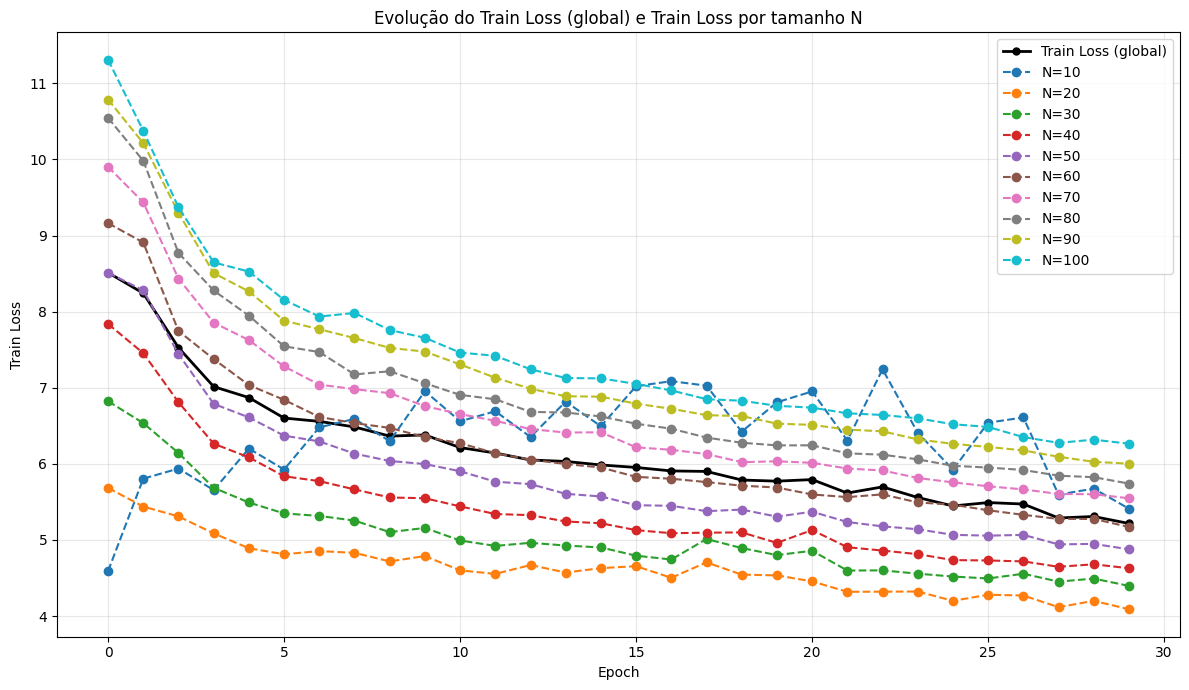

In [30]:
plot_training_losses(history)

# Load saved checkpoint

In [68]:
if notebook_mode==True:
    # Load checkpoint
    log_dir = f"./logs/{config.expt_name}/"
    if torch.cuda.is_available():
        checkpoint = torch.load(log_dir+"best_val_checkpoint.tar")
    else:
        checkpoint = torch.load(log_dir+"best_val_checkpoint.tar", map_location='cpu')
    # Load network state
    net.load_state_dict(checkpoint['model_state_dict'])
    # Load optimizer state
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    # Load other training parameters
    epoch = checkpoint['epoch']
    train_loss = checkpoint['train_loss']
    val_loss = checkpoint['val_loss']
    for param_group in optimizer.param_groups:
        learning_rate = param_group['lr']
    print(f"Loaded checkpoint from epoch {epoch}")

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy._core.multiarray.scalar was not an allowed global by default. Please use `torch.serialization.add_safe_globals([numpy._core.multiarray.scalar])` or the `torch.serialization.safe_globals([numpy._core.multiarray.scalar])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

# Visualize model predictions

In [31]:
import numpy as np

# Correção temporária para o NumPy 2.0
if not hasattr(np, 'alltrue'):
    np.alltrue = np.all

🔧 Construindo input baseado em: ['coords', 'closeness']
✅ Input final montado com shape: torch.Size([20, 10, 3])
Predicted tour length: 52.251 (mean)
Groundtruth tour length: 52.251 (mean)


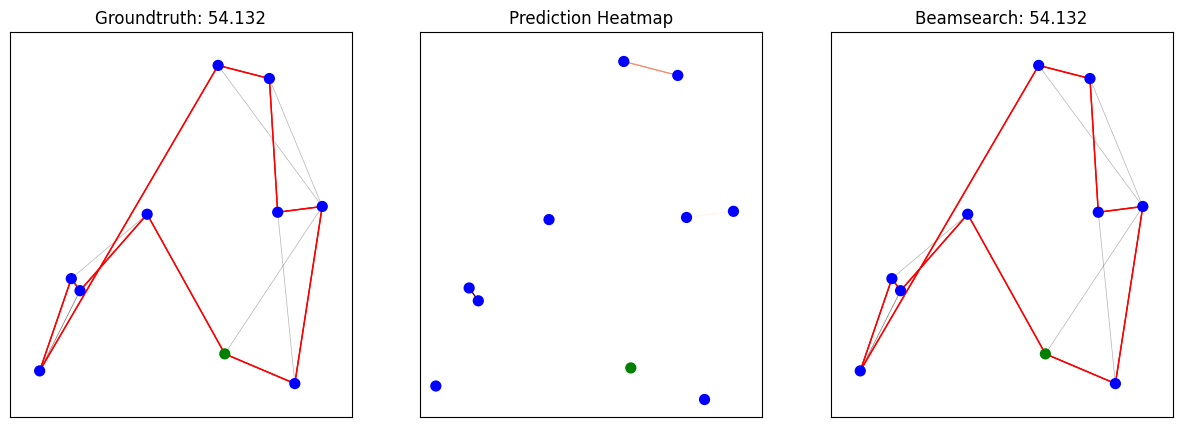

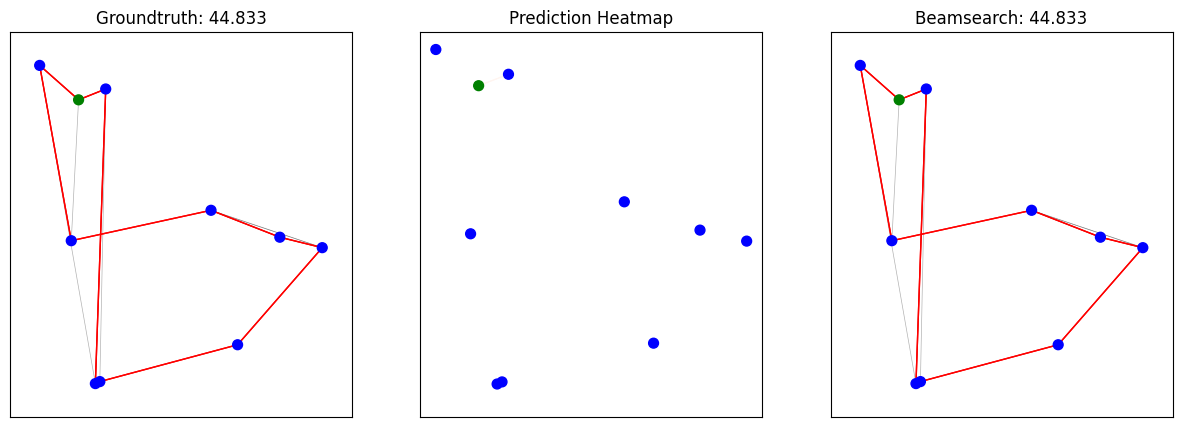

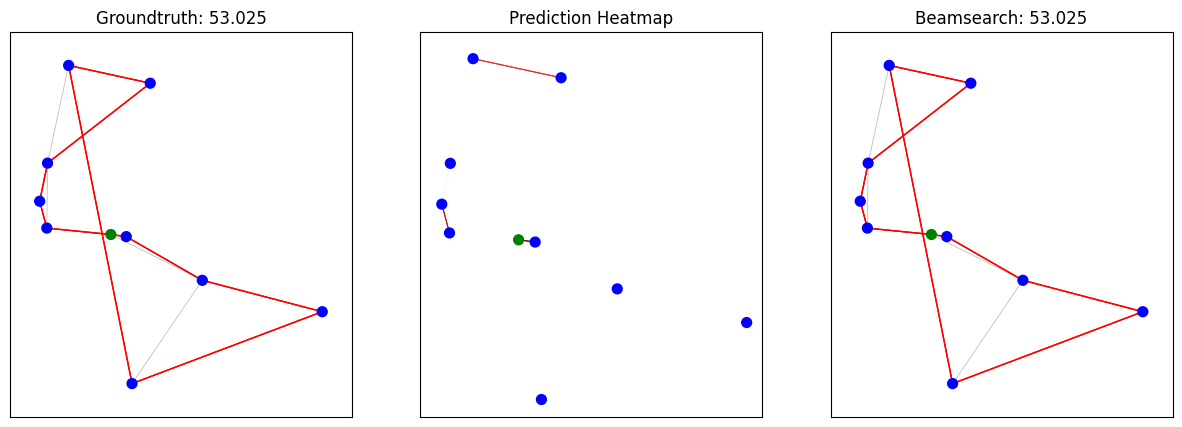

In [33]:
if notebook_mode==True:
    # Set evaluation mode
    net.eval()

    # Importações necessárias
    import networkx as nx
    from scipy.spatial import distance_matrix
    import numpy as np
    import torch

    batch_size = config.batch_size
    num_nodes = config.num_nodes
    knn_ratio = config.knn_ratio
    beam_size = config.beam_size
    test_filepath = config.test_filepath
    dataset = iter(VariableTSPReader(test_filepath, batch_size, knn_ratio=config.knn_ratio, metric=config.metric))
    batch = next(dataset)

    N = batch.nodes.shape[1]

    with torch.no_grad():
        # Variáveis básicas
        x_edges = Variable(torch.LongTensor(batch.edges).type(dtypeLong), requires_grad=False)
        x_edges_values = Variable(torch.FloatTensor(batch.edges_values).type(dtypeFloat), requires_grad=False)
        x_nodes = Variable(torch.LongTensor(batch.nodes).type(dtypeLong), requires_grad=False)
        x_nodes_coord = Variable(torch.FloatTensor(batch.nodes_coord).type(dtypeFloat), requires_grad=False)

        # --- PARTE INTELIGENTE: MONTAGEM DINÂMICA COMPLETA ---
        feature_list = [x_nodes_coord]

        print(f"🔧 Construindo input baseado em: {ACTIVE_FEATURES}")

        if len(ACTIVE_FEATURES) > 1:
            batch_curr = x_nodes_coord.shape[0]
            nodes_curr = x_nodes_coord.shape[1]
            k_neighbors = max(2, int(nodes_curr / 5))

            # Inicializa tensores para TODAS as possibilidades
            feat_degree = torch.zeros(batch_curr, nodes_curr, 1).type(dtypeFloat)
            feat_cluster = torch.zeros(batch_curr, nodes_curr, 1).type(dtypeFloat)
            feat_pagerank = torch.zeros(batch_curr, nodes_curr, 1).type(dtypeFloat)
            feat_closeness = torch.zeros(batch_curr, nodes_curr, 1).type(dtypeFloat)
            feat_betweenness = torch.zeros(batch_curr, nodes_curr, 1).type(dtypeFloat)

            for b in range(batch_curr):
                pts = x_nodes_coord[b].cpu().numpy()
                dist = distance_matrix(pts, pts)
                adj = np.zeros((nodes_curr, nodes_curr))
                for i in range(nodes_curr):
                    idx = np.argsort(dist[i])[1:k_neighbors+1]
                    adj[i, idx] = 1; adj[idx, i] = 1
                G_nx = nx.from_numpy_array(adj)

                # Preenche conforme solicitado
                if 'degree' in ACTIVE_FEATURES:
                    d = dict(G_nx.degree())
                    for i in range(nodes_curr): feat_degree[b, i, 0] = d[i]

                if 'cluster' in ACTIVE_FEATURES:
                    c = nx.clustering(G_nx)
                    for i in range(nodes_curr): feat_cluster[b, i, 0] = c[i]

                if 'pagerank' in ACTIVE_FEATURES:
                    try: p = nx.pagerank(G_nx)
                    except: p = {i:0 for i in range(nodes_curr)}
                    for i in range(nodes_curr): feat_pagerank[b, i, 0] = p[i]

                # --- AQUI ESTAVA FALTANDO ---
                if 'closeness' in ACTIVE_FEATURES:
                    cl = nx.closeness_centrality(G_nx)
                    for i in range(nodes_curr): feat_closeness[b, i, 0] = cl[i]

                if 'betweenness' in ACTIVE_FEATURES:
                    bt = nx.betweenness_centrality(G_nx)
                    for i in range(nodes_curr): feat_betweenness[b, i, 0] = bt[i]

            # Move para GPU se necessário
            if torch.cuda.is_available():
                feat_degree = feat_degree.cuda(); feat_cluster = feat_cluster.cuda()
                feat_pagerank = feat_pagerank.cuda(); feat_closeness = feat_closeness.cuda()
                feat_betweenness = feat_betweenness.cuda()

            # Adiciona na lista na ordem correta
            if 'degree' in ACTIVE_FEATURES: feature_list.append(feat_degree)
            if 'cluster' in ACTIVE_FEATURES: feature_list.append(feat_cluster)
            if 'pagerank' in ACTIVE_FEATURES: feature_list.append(feat_pagerank)
            if 'closeness' in ACTIVE_FEATURES: feature_list.append(feat_closeness)
            if 'betweenness' in ACTIVE_FEATURES: feature_list.append(feat_betweenness)

        x_nodes_full = torch.cat(feature_list, dim=2)
        print(f"Input final montado com shape: {x_nodes_full.shape}")
        # -----------------------------------------------------------

        y_edges = Variable(torch.LongTensor(batch.edges_target).type(dtypeLong), requires_grad=False)
        y_nodes = Variable(torch.LongTensor(batch.nodes_target).type(dtypeLong), requires_grad=False)

        edge_labels = y_edges.cpu().numpy().flatten()
        edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)

        y_preds, loss = net.forward(x_edges, x_edges_values, x_nodes, x_nodes_full, y_edges, edge_cw)
        loss = loss.mean()

        bs_nodes = beamsearch_tour_nodes_shortest(
            y_preds, x_edges_values, beam_size, batch_size, N, dtypeFloat, dtypeLong, probs_type='logits')

        pred_tour_len = mean_tour_len_nodes(x_edges_values, bs_nodes)
        gt_tour_len = np.mean(batch.tour_len)
        print("Predicted tour length: {:.3f} (mean)\nGroundtruth tour length: {:.3f} (mean)".format(pred_tour_len, gt_tour_len))

        plot_predictions_beamsearch(x_nodes_coord, x_edges, x_edges_values, y_edges, y_preds, bs_nodes, num_plots=3)

## Metrics

In [36]:
# Atualização da função de avaliação para suportar features dinâmicas
def evaluate_full_testset_per_graph(net, config):
    net.eval()

    import torch
    from torch.autograd import Variable
    import numpy as np
    import networkx as nx
    from scipy.spatial import distance_matrix
    from sklearn.utils.class_weight import compute_class_weight

    batch_size = config.batch_size
    beam_size = config.beam_size
    test_filepath = config.test_filepath
    dtypeFloat = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
    dtypeLong = torch.cuda.LongTensor if torch.cuda.is_available() else torch.LongTensor

    dataset = VariableTSPReader(test_filepath, batch_size, knn_ratio=config.knn_ratio, metric=config.metric)

    pred_tour_lens = []
    gt_tour_lens = []
    gaps = []
    losses = []
    results_by_N = {}

    print(f"Iniciando Avaliação Genérica com: {ACTIVE_FEATURES}")

    with torch.no_grad():
        for i, batch in enumerate(dataset):
            # Variáveis básicas
            x_edges = Variable(torch.LongTensor(batch.edges).type(dtypeLong), requires_grad=False)
            x_edges_values = Variable(torch.FloatTensor(batch.edges_values).type(dtypeFloat), requires_grad=False)
            x_nodes = Variable(torch.LongTensor(batch.nodes).type(dtypeLong), requires_grad=False)
            x_nodes_coord = Variable(torch.FloatTensor(batch.nodes_coord).type(dtypeFloat), requires_grad=False)
            y_edges = Variable(torch.LongTensor(batch.edges_target).type(dtypeLong), requires_grad=False)

            # --- Cálculo Dinâmico das Features ---
            feature_list = [x_nodes_coord]

            if len(ACTIVE_FEATURES) > 1:
                batch_curr = x_nodes_coord.shape[0]
                nodes_curr = x_nodes_coord.shape[1]
                k_neighbors = max(2, int(nodes_curr / 5))

                # Inicializa tensores
                feat_degree = torch.zeros(batch_curr, nodes_curr, 1).type(dtypeFloat)
                feat_cluster = torch.zeros(batch_curr, nodes_curr, 1).type(dtypeFloat)
                feat_pagerank = torch.zeros(batch_curr, nodes_curr, 1).type(dtypeFloat)
                feat_closeness = torch.zeros(batch_curr, nodes_curr, 1).type(dtypeFloat)
                feat_betweenness = torch.zeros(batch_curr, nodes_curr, 1).type(dtypeFloat)

                for b in range(batch_curr):
                    pts = x_nodes_coord[b].cpu().numpy()
                    dist = distance_matrix(pts, pts)
                    adj = np.zeros((nodes_curr, nodes_curr))
                    for k in range(nodes_curr):
                        idx = np.argsort(dist[k])[1:k_neighbors+1]
                        adj[k, idx] = 1; adj[idx, k] = 1
                    G_nx = nx.from_numpy_array(adj)

                    # Calcula apenas o que está na lista ACTIVE_FEATURES
                    if 'degree' in ACTIVE_FEATURES:
                        d = dict(G_nx.degree())
                        for n in range(nodes_curr): feat_degree[b, n, 0] = d[n]
                    if 'cluster' in ACTIVE_FEATURES:
                        c = nx.clustering(G_nx)
                        for n in range(nodes_curr): feat_cluster[b, n, 0] = c[n]
                    if 'pagerank' in ACTIVE_FEATURES:
                        try: p = nx.pagerank(G_nx)
                        except: p = {n:0 for n in range(nodes_curr)}
                        for n in range(nodes_curr): feat_pagerank[b, n, 0] = p[n]
                    if 'closeness' in ACTIVE_FEATURES:
                        cl = nx.closeness_centrality(G_nx)
                        for n in range(nodes_curr): feat_closeness[b, n, 0] = cl[n]
                    if 'betweenness' in ACTIVE_FEATURES:
                        bt = nx.betweenness_centrality(G_nx)
                        for n in range(nodes_curr): feat_betweenness[b, n, 0] = bt[n]

                if torch.cuda.is_available():
                    feat_degree = feat_degree.cuda()
                    feat_cluster = feat_cluster.cuda()
                    feat_pagerank = feat_pagerank.cuda()
                    feat_closeness = feat_closeness.cuda()
                    feat_betweenness = feat_betweenness.cuda()

                # Monta a lista na ordem correta
                if 'degree' in ACTIVE_FEATURES: feature_list.append(feat_degree)
                if 'cluster' in ACTIVE_FEATURES: feature_list.append(feat_cluster)
                if 'pagerank' in ACTIVE_FEATURES: feature_list.append(feat_pagerank)
                if 'closeness' in ACTIVE_FEATURES: feature_list.append(feat_closeness)
                if 'betweenness' in ACTIVE_FEATURES: feature_list.append(feat_betweenness)

            x_nodes_full = torch.cat(feature_list, dim=2)
            # -----------------------------------------------------------

            # Pesos e Forward Pass
            edge_labels = y_edges.cpu().numpy().flatten()
            edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)

            y_preds, loss = net.forward(x_edges, x_edges_values, x_nodes, x_nodes_full, y_edges, edge_cw)
            losses.append(loss.mean().item())

            # Beamsearch
            bs_nodes = beamsearch_tour_nodes_shortest(
                y_preds, x_edges_values, beam_size, batch_size, x_nodes.shape[1], dtypeFloat, dtypeLong, probs_type='logits')

            # Métricas
            pred_len = mean_tour_len_nodes(x_edges_values, bs_nodes)
            gt_len = np.mean(batch.tour_len)
            current_gap = (pred_len - gt_len) / gt_len

            pred_tour_lens.append(pred_len)
            gt_tour_lens.append(gt_len)
            gaps.append(current_gap)

            # Agrupa resultados por tamanho N
            N_size = x_nodes.shape[1]
            if N_size not in results_by_N:
                results_by_N[N_size] = []
            results_by_N[N_size].append(current_gap)

            if i % 10 == 0:
                print(f"Batch {i} | N={N_size} | Gap={current_gap:.4f}")

    return {'mean_gap': np.mean(gaps), 'mean_loss': np.mean(losses)}, results_by_N

print("Função evaluate_full_testset_per_graph atualizada com sucesso.")

Função evaluate_full_testset_per_graph atualizada com sucesso.


In [37]:
global_results, results_by_N = evaluate_full_testset_per_graph(net, config)

Iniciando Avaliação Genérica com: ['coords', 'closeness']
Batch 0 | N=10 | Gap=-0.0000
Batch 10 | N=30 | Gap=0.0398
Batch 20 | N=40 | Gap=0.0697
Batch 30 | N=60 | Gap=0.1425
Batch 40 | N=80 | Gap=0.1722
Batch 50 | N=100 | Gap=0.2088


In [112]:
global_results

{'mean_pred_tour_len': np.float32(129.42924),
 'mean_gt_tour_len': np.float64(110.47102692307693),
 'mean_gap': np.float64(0.14438153174420842),
 'mean_loss': np.float64(20.834599935091457)}

In [81]:
plot_results_by_N(results_by_N)

TypeError: list indices must be integers or slices, not str

📊 Processando estatísticas para o gráfico...
N=10: Média=0.0002
N=20: Média=0.0022
N=30: Média=0.0340
N=40: Média=0.0916
N=50: Média=0.1587
N=60: Média=0.1807
N=70: Média=0.2240
N=80: Média=0.2282
N=90: Média=0.2586
N=100: Média=0.2660

Gerando Gráfico...


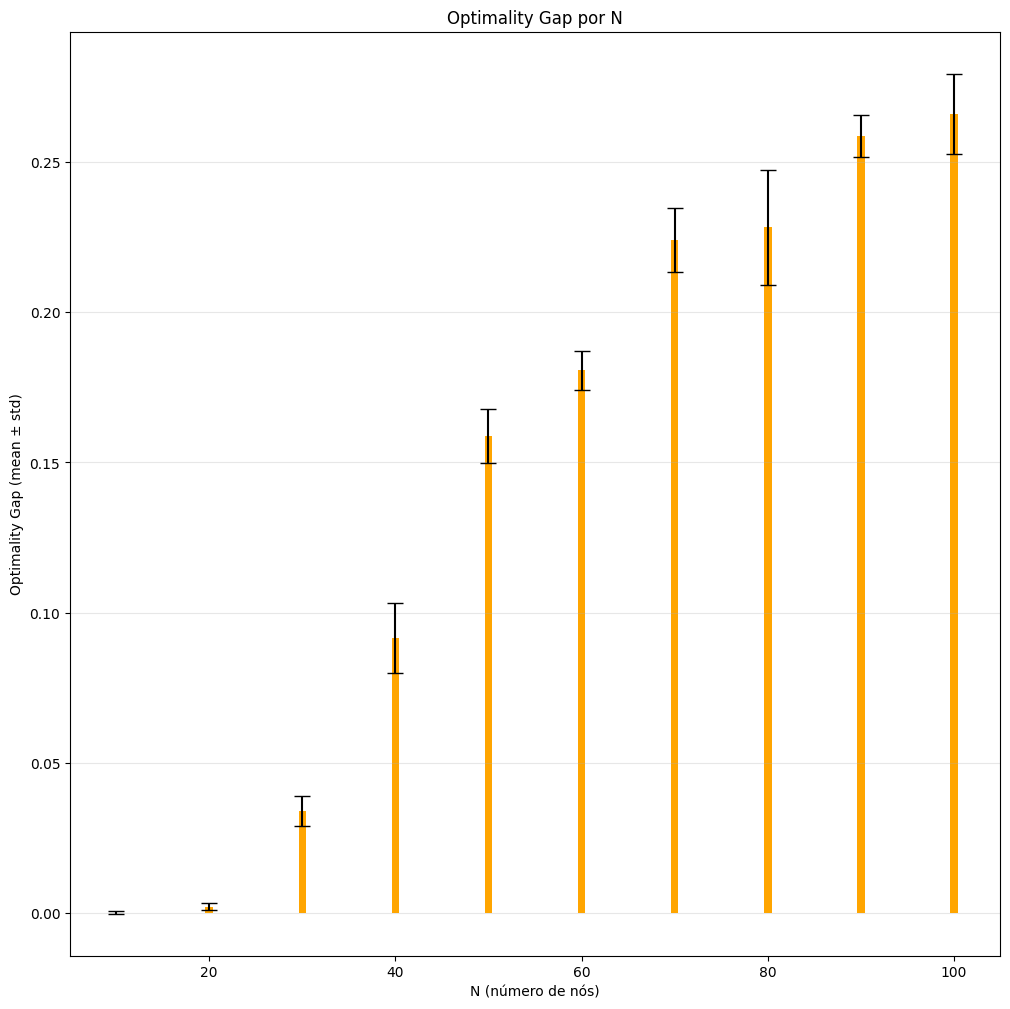

In [113]:
import numpy as np

# 1. Cria um novo dicionário no formato que o gráfico gosta
results_processed = {}

print("📊 Processando estatísticas para o gráfico...")

for N, gaps_list in results_by_N.items():
    # Converte a lista bruta de gaps em Média e Desvio Padrão
    results_processed[N] = {
        "mean_gap": np.mean(gaps_list),
        "std_gap": np.std(gaps_list)
    }
    print(f"N={N}: Média={np.mean(gaps_list):.4f}")

# 2. Agora sim, plotamos usando o dicionário corrigido
print("\nGerando Gráfico...")
plot_results_by_N(results_processed)